In [3]:
 #Loading mri dataset as a zipfile
from zipfile import ZipFile
dataset = "alzheimerdataset.zip"

In [5]:
#extracting zip file
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# Importing Libraries

In [45]:
import numpy as np
import pandas as pd
import tensorflow 
import keras  
import os
import glob 
from sklearn.model_selection import train_test_split
from skimage import io 
import random 
import warnings
from skimage.color import rgb2gray
from skimage import filters
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import histogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
import cv2
#from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam


warnings.filterwarnings("ignore")  # To suppress unnecessary warnings

# Set the style using seaborn
sns.set(style='whitegrid')  # Adjust the style as needed


## Image Peprocessing

In [46]:
#preparing data
import os
path = os.listdir('AlzheimerDataset')
classes = {'NonDemented':0, 'MildDemented':1, 'ModerateDemented':2, 'VeryMildDemented':3}

In [47]:
import cv2
X = []
Y = []
for cls in classes:
    pth = 'AlzheimerDataset/train/'+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 0)
        img = cv2.resize(img, (128,128))
        X.append(img)
        Y.append(classes[cls])

In [52]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
X_updated = X.reshape(len(X), -1)

(5121, 128, 128)


In [53]:
np.unique(Y)

array([0, 1, 2, 3])

In [54]:
np.unique(Y)
pd.Series(Y).value_counts()

0    2560
3    1792
1     717
2      52
dtype: int64

In [55]:
X.shape, X_updated.shape

((5121, 128, 128), (5121, 16384))

In [56]:
try:
    print('RESIZED', X[15].shape)
except AttributeError:
    print("shape not found")

RESIZED (128, 128)


In [57]:
def displayImg(img):
  plt.imshow(img, cmap='gray')

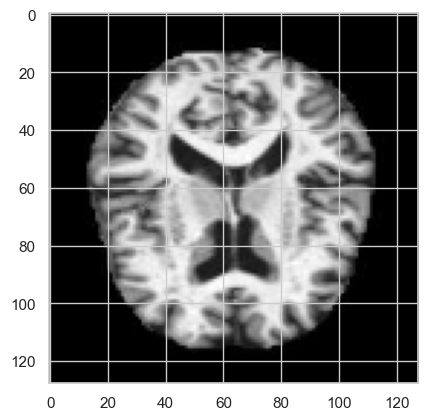

In [58]:
#visualizing the data
displayImg(X[777])

In [59]:
#denoising and enchancing
i=0
contrast = 0.8
bright = 2
for img in X:
  X[i] = cv2.bilateralFilter(X[i],10,5,5)
  X[i] = np.clip(contrast*X[i]+bright,0,255)

  i=i+1

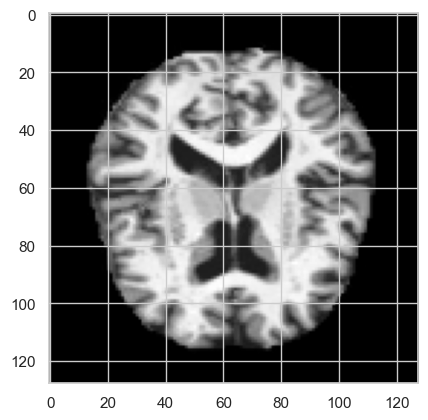

In [60]:
displayImg(X[777])

In [61]:
# grayscale = rgb2gray(X[777])#Edge Detection
grayscale = X[777]
ed_sobel = filters.sobel(X[777])

Text(0, 0.5, 'Number of pixels')

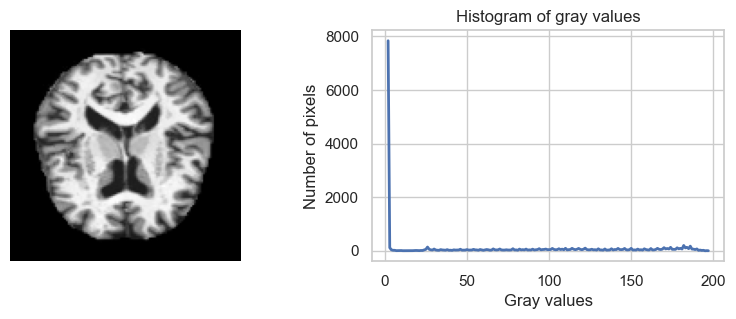

In [62]:
hist, hist_centers = histogram(grayscale)
#Plotting the Image and the Histogram of gray values
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].imshow(grayscale, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of gray values')
plt.xlabel("Gray values")
plt.ylabel("Number of pixels")

Saturated (128, 128)


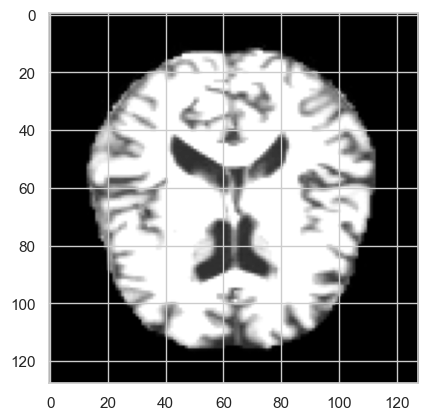

In [63]:
# Applying OpenCV addition on images
fimg1 = cv2.add(X[777], X[888])
displayImg(fimg1)
print('Saturated',fimg1.shape)

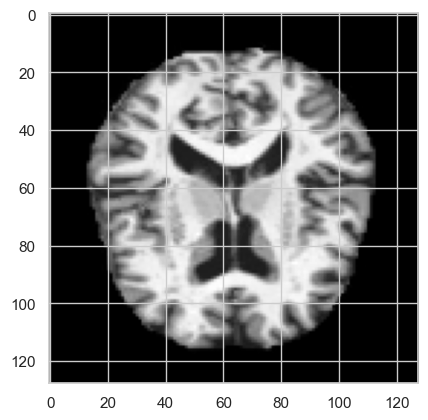

In [64]:
# Applying NumPy scalar multiplication on image
fimg2 = X[777]  * 5.5
displayImg(fimg2)

In [65]:
xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10,test_size=.3)
xtrain.shape, xtest.shape

((3584, 16384), (1537, 16384))

In [66]:
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())
xtrain = xtrain/255
xtest = xtest/255
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())

204 2
205 2
0.8 0.00784313725490196
0.803921568627451 0.00784313725490196


## SVM

##Train Model

In [67]:
sv = SVC(kernel='rbf')
sv.fit(xtrain, ytrain)

SVC()

##Evaluation

In [ ]:
print("Training Score:", sv.score(xtrain, ytrain))
print("Testing Score:", sv.score(xtest, ytest))


# Prediction

In [72]:
pred = sv.predict(xtest)

In [73]:
misclassified = np.where(pred != ytest)
print("Total Misclassified Samples: ",len(misclassified[0]))
print(pred[36],ytest[36])

Total Misclassified Samples:  380
3 3


## ACCURACY

In [102]:
sv.fit(xtrain, ytrain)
predicted = sv.predict(xtest)
svmacc = accuracy_score(ytest,predicted)
print (svmacc)



0.752765126870527


##COnfusion Matrix

In [62]:
cf_matrix= confusion_matrix(predicted,ytest)
cf_matrix

array([[707,  52,   3, 153],
       [  0,  69,   0,   0],
       [  0,   0,   1,   0],
       [ 67,  99,   6, 380]], dtype=int64)

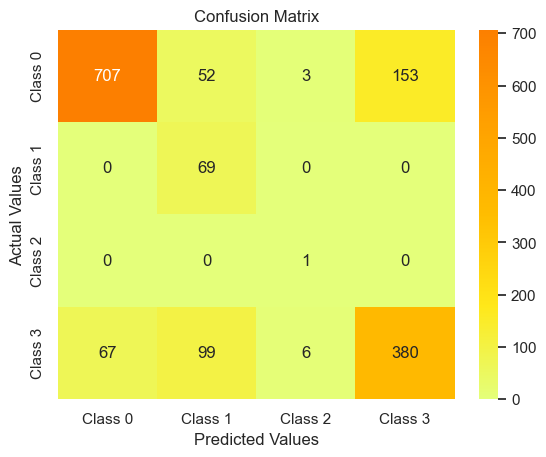

In [71]:
df_cm = pd.DataFrame(confusion_matrix, index=['Class 0', 'Class 1', 'Class 2', 'Class 3'], columns=['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Generate the heatmap with annotations and a specified color map
ax = sns.heatmap(df_cm, annot=True, cmap='Wistia', fmt='d')  # 'fmt='d'' ensures integers are shown properly

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Display the visualization of the Confusion Matrix
plt.show()

## classification report for svm

In [74]:
from sklearn.metrics import classification_report

# Identify the unique classes in your predicted values
unique_classes = sorted(set(predicted))  # Consider using ytest if predicted is not available

# Update the target_names list according to the unique classes
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Update with the actual class names or labels

# Print the classification report with the correct target names
print(classification_report(ytest, predicted, target_names=target_names))


              precision    recall  f1-score   support

     Class 0       0.77      0.91      0.84       774
     Class 1       1.00      0.31      0.48       220
     Class 2       1.00      0.10      0.18        10
     Class 3       0.69      0.71      0.70       533

    accuracy                           0.75      1537
   macro avg       0.87      0.51      0.55      1537
weighted avg       0.78      0.75      0.73      1537



In [130]:
svmprec = precision_score(ytest,predicted,average='macro')	
print(svmprec)

0.8652708481824661


In [131]:
svmrec = recall_score(ytest,predicted,average='macro')
print(rfrec)

0.3703098880069952


In [132]:
svmf = f1_score(ytest,predicted,average='macro')
print(rff)

0.35070528600957696


## TESTING MODEL for SVM

In [105]:
dec = {'NonDemented':0, 'MildDemented':1, 'ModerateDemented':2, 'VeryMildDemented':3}

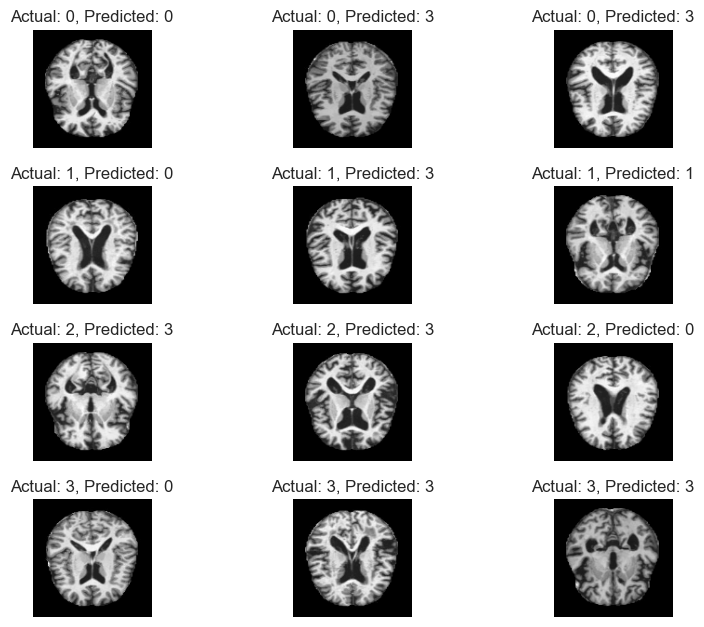

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predicted_labels, y_test, and x_test available

# Group indices of the test data by their actual labels
class_indices = {}
for idx, label in enumerate(ytest):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)

# Predict on the test set
predicted_labels = sv.predict(xtest)

# Display a representative image from each class
num_classes_to_display = 5  # Number of classes to display
images_per_class = 3  # Number of images per class to display

plt.figure(figsize=(8, 8))
for class_label in list(class_indices.keys())[:num_classes_to_display]:
    indices = class_indices[class_label][:images_per_class]
    for i, idx in enumerate(indices):
        image = xtest[idx].reshape(128, 128)  # Assuming the image size is 128x128
        plt.subplot(num_classes_to_display, images_per_class, class_label * images_per_class + i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Actual: {ytest[idx]}, Predicted: {predicted_labels[idx]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


## Random Forest

In [78]:
mod=RandomForestClassifier(n_estimators=700,max_depth=4)

In [79]:
mod.fit(xtrain,ytrain)


RandomForestClassifier(max_depth=4, n_estimators=700)

In [80]:
y_pred=mod.predict(xtest)

In [81]:
misclassified=np.where(ytest!=y_pred)
misclassified
print("Total Misclassified Samples: ",len(misclassified[0]))
print(y_pred[36],ytest[36])

Total Misclassified Samples:  554
3 3


In [82]:
rfacc=accuracy_score(ytest,y_pred)
print(rfacc)
##print(classification_report(y_pred,ytest))

0.6395575797007157


In [133]:
rfprec = precision_score(ytest,y_pred,average='macro')
print(rfprec)

0.5593903590320116


In [134]:
rfrec = recall_score(ytest,y_pred,average='macro')
print(rfrec)

0.3703098880069952


In [135]:
rff = f1_score(ytest,y_pred,average='macro')
print(rff)

0.35070528600957696


##Confusion Matrix

In [86]:
cf_matrix=confusion_matrix(y_pred,ytest)
print(cf_matrix)

[[658  57   5 216]
 [  0   8   0   0]
 [  0   0   0   0]
 [116 155   5 317]]


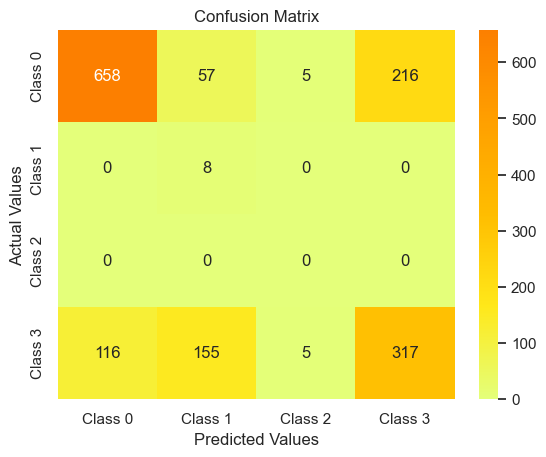

In [87]:
df_cm = pd.DataFrame(cf_matrix, index=['Class 0', 'Class 1', 'Class 2', 'Class 3'], columns=['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Generate the heatmap with annotations and a specified color map
ax = sns.heatmap(df_cm, annot=True, cmap='Wistia', fmt='d')  # 'fmt='d'' ensures integers are shown properly

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Display the visualization of the Confusion Matrix
plt.show()

In [89]:
predi=mod.predict(xtest)

# Identify the unique classes in your predicted values
unique_classes = sorted(set(predi))  # Consider using ytest if predicted is not available

# Update the target_names list according to the unique classes
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Update with the actual class names or labels

# Print the classification report with the correct target names
print(classification_report(ytest, y_pred, target_names=target_names))


              precision    recall  f1-score   support

     Class 0       0.70      0.85      0.77       774
     Class 1       1.00      0.04      0.07       220
     Class 2       0.00      0.00      0.00        10
     Class 3       0.53      0.59      0.56       533

    accuracy                           0.64      1537
   macro avg       0.56      0.37      0.35      1537
weighted avg       0.68      0.64      0.59      1537



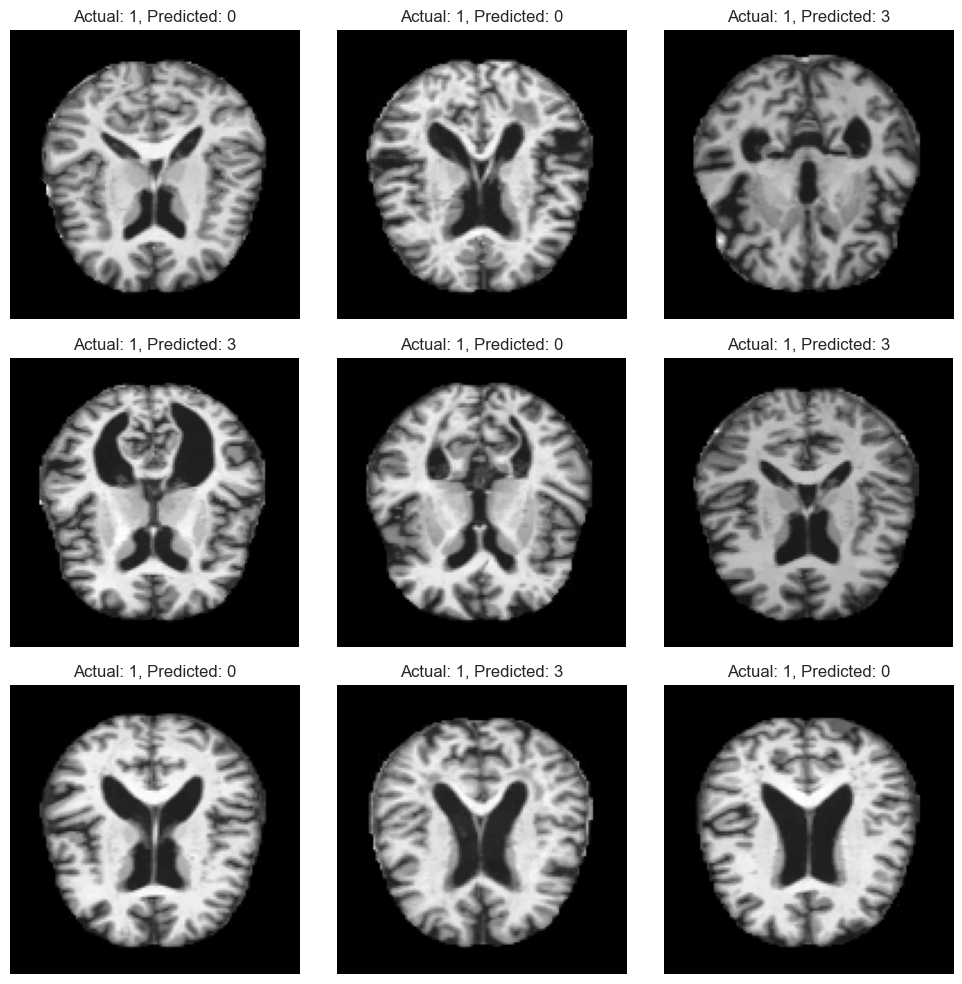

In [91]:
##with same class
predicted_labels = mod.predict(xtest)
num_images = 9  # Number of images you want to display
plt.figure(figsize=(10, 10))
for i in range(num_images):
    image = xtest[i].reshape(128, 128)  # Assuming the image size is 128x128
    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_labels[i]}")
    #plt.title(f"Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

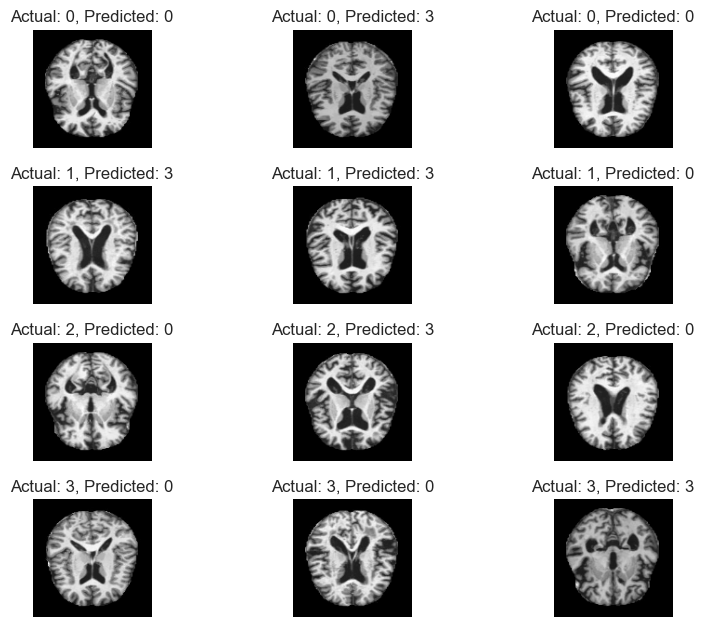

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predicted_labels, y_test, and x_test available

# Group indices of the test data by their actual labels
class_indices = {}
for idx, label in enumerate(ytest):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)

# Predict on the test set
predicted_labels = mod.predict(xtest)

# Display a representative image from each class
num_classes_to_display = 5  # Number of classes to display
images_per_class = 3  # Number of images per class to display

plt.figure(figsize=(8, 8))
for class_label in list(class_indices.keys())[:num_classes_to_display]:
    indices = class_indices[class_label][:images_per_class]
    for i, idx in enumerate(indices):
        image = xtest[idx].reshape(128, 128)  # Assuming the image size is 128x128
        plt.subplot(num_classes_to_display, images_per_class, class_label * images_per_class + i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Actual: {ytest[idx]}, Predicted: {predicted_labels[idx]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


# performance measure

In [138]:
def cm_to_inch(value):
    return value/2.54

In [139]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', fontsize=12, color='black')

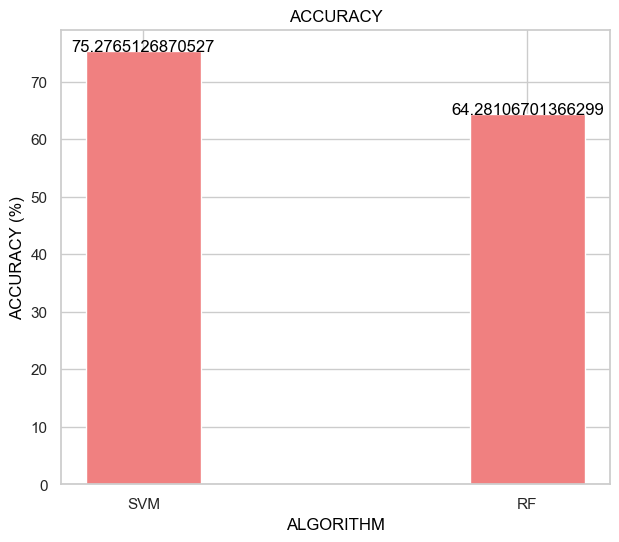

In [141]:
x = np.array(["SVM","RF"])
y = np.array([svmacc*100,rfacc*100])
plt.figure(figsize=(cm_to_inch(18), cm_to_inch(15)))
plt.bar(x,y, width = 0.3, color='lightcoral')
addlabels(x,y) 
plt.title('ACCURACY', color='black')
plt.xlabel("ALGORITHM", color='black')
plt.ylabel("ACCURACY (%)",color='black')
plt.show()

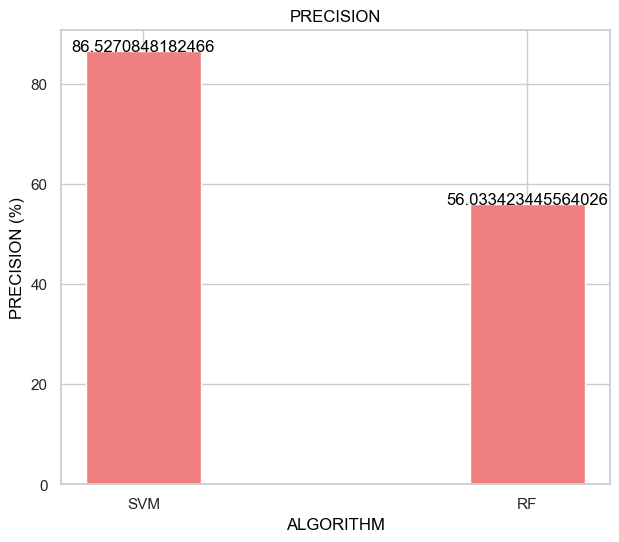

In [150]:
x = np.array(["SVM","RF"])
y = np.array([svmprec*100,rfprec*100])
plt.figure(figsize=(cm_to_inch(18), cm_to_inch(15)))
plt.bar(x,y, width = 0.3, color='lightcoral')
addlabels(x,y)
plt.title('PRECISION', color='black')
plt.xlabel("ALGORITHM", color='black')
plt.ylabel("PRECISION (%)", color='black')
plt.show()

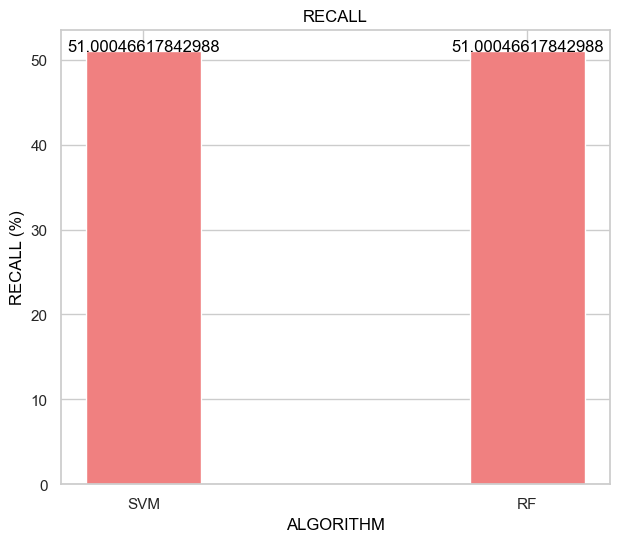

In [159]:
x = np.array(["SVM","RF"])
y = np.array([svmrec*100,rfrec*100])
plt.figure(figsize=(cm_to_inch(18), cm_to_inch(15)))
plt.bar(x,y, width = 0.3, color='lightcoral')
addlabels(x,y)
plt.title('RECALL', color='black')
plt.xlabel("ALGORITHM", color='black')
plt.ylabel("RECALL (%)", color='black')
plt.show()

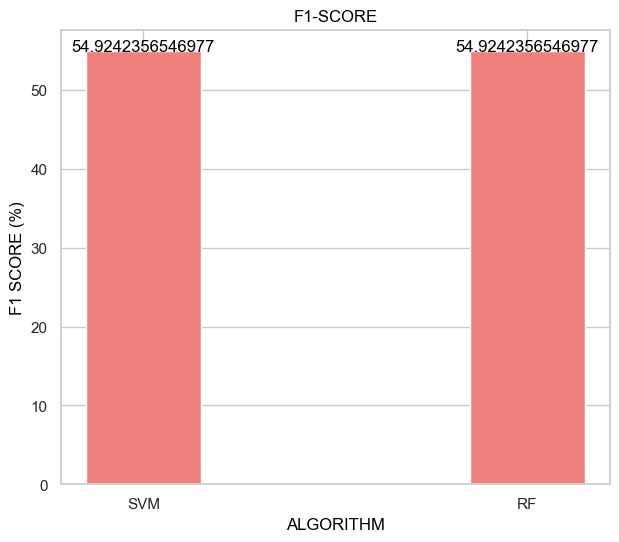

In [160]:
x = np.array(["SVM","RF"])
y = np.array([svmf*100,rff*100])
plt.figure(figsize=(cm_to_inch(18), cm_to_inch(15)))
plt.bar(x,y, width = 0.3, color='lightcoral')
addlabels(x,y)
plt.title('F1-SCORE', color='black')
plt.xlabel("ALGORITHM", color='black')
plt.ylabel("F1 SCORE (%)", color='black')
plt.show()

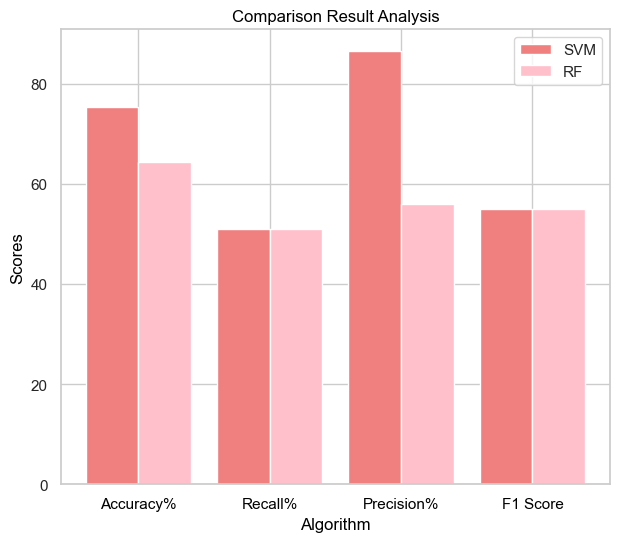

In [161]:
X = ['Accuracy%', 'Recall%', 'Precision%', 'F1 Score']
svm_stats = [svmacc*100, svmrec*100, svmprec*100, svmf*100]
rf_stats = [rfacc*100, rfrec*100, rfprec*100, rff*100]

X_axis = np.arange(len(X))
plt.figure(figsize=(cm_to_inch(18), cm_to_inch(15)))

plt.bar(X_axis - 0.2, svm_stats, 0.4, label = 'SVM', color='lightcoral')
plt.bar(X_axis + 0.2, rf_stats, 0.4, label = 'RF', color='pink')

plt.xticks(X_axis, X, color='black')
plt.xlabel("Algorithm", color='black')
plt.ylabel("Scores", color='black')
plt.title("Comparison Result Analysis", color='black')
plt.legend()
plt.show()


## CNN

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
#preparing data
import os
path = os.listdir('AlzheimerDataset')
classes = {'NonDemented':0, 'MildDemented':1, 'ModerateDemented':2, 'VeryMildDemented':3}
import cv2
X = []
Y = []
for cls in classes:
    pth = 'AlzheimerDataset/train/'+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 0)
        img = cv2.resize(img, (128,128))
        X.append(img)
        Y.append(classes[cls])

X = np.array(X)
Y = np.array(Y)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Encode class labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert class labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Normalize the image data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Build the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # Output layer with 4 units for 4 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/10
116/116 [==============================] - 71s 598ms/step - loss: 1.0205 - accuracy: 0.5222 - val_loss: 0.8846 - val_accuracy: 0.5951
Epoch 2/10
116/116 [==============================] - 80s 687ms/step - loss: 0.7932 - accuracy: 0.6346 - val_loss: 0.8778 - val_accuracy: 0.5683
Epoch 3/10
116/116 [==============================] - 82s 710ms/step - loss: 0.5987 - accuracy: 0.7368 - val_loss: 0.4702 - val_accuracy: 0.8244
Epoch 4/10
116/116 [==============================] - 78s 675ms/step - loss: 0.3326 - accuracy: 0.8695 - val_loss: 0.2448 - val_accuracy: 0.9000
Epoch 5/10
116/116 [==============================] - 81s 699ms/step - loss: 0.1354 - accuracy: 0.9536 - val_loss: 0.1634 - val_accuracy: 0.9683
Epoch 6/10
116/116 [==============================] - 90s 776ms/step - loss: 0.0613 - accuracy: 0.9826 - val_loss: 0.3017 - val_accuracy: 0.8805
Epoch 7/10
116/116 [==============================] - 97s 835ms/step - loss: 0.0379 - accuracy: 0.9875 - val_loss: 0.2151 - val_ac

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Encode class labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert class labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Normalize the image data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [137]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

pred_labels = model.predict(X_test)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))

33/33 [==============================] - 4s 116ms/step
                  precision    recall  f1-score   support

     NonDemented       1.00      0.98      0.99       535
VeryMildDemented       0.98      1.00      0.99       127
    MildDemented       1.00      0.92      0.96        12
ModerateDemented       0.97      0.99      0.98       351

       micro avg       0.99      0.99      0.99      1025
       macro avg       0.99      0.97      0.98      1025
    weighted avg       0.99      0.99      0.99      1025
     samples avg       0.99      0.99      0.99      1025



In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Assuming model.predict returns the predicted probabilities
# Replace model.predict with the function that predicts the probabilities using your CNN model

# Example predictions using the trained model
predicted_probs = model.predict(X_test)

# Convert the predicted probabilities to class labels
predicted_classes = np.argmax(predicted_probs, axis=1)

# Convert one-hot encoded true labels to class labels
true_classes = np.argmax(y_test, axis=1)

# Precision, Recall, and F1 Score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


33/33 [==============================] - 4s 108ms/step
Precision: 0.9847038370647929
Recall: 0.984390243902439
F1 Score: 0.9843965700425242


33/33 [==============================] - 6s 163ms/step


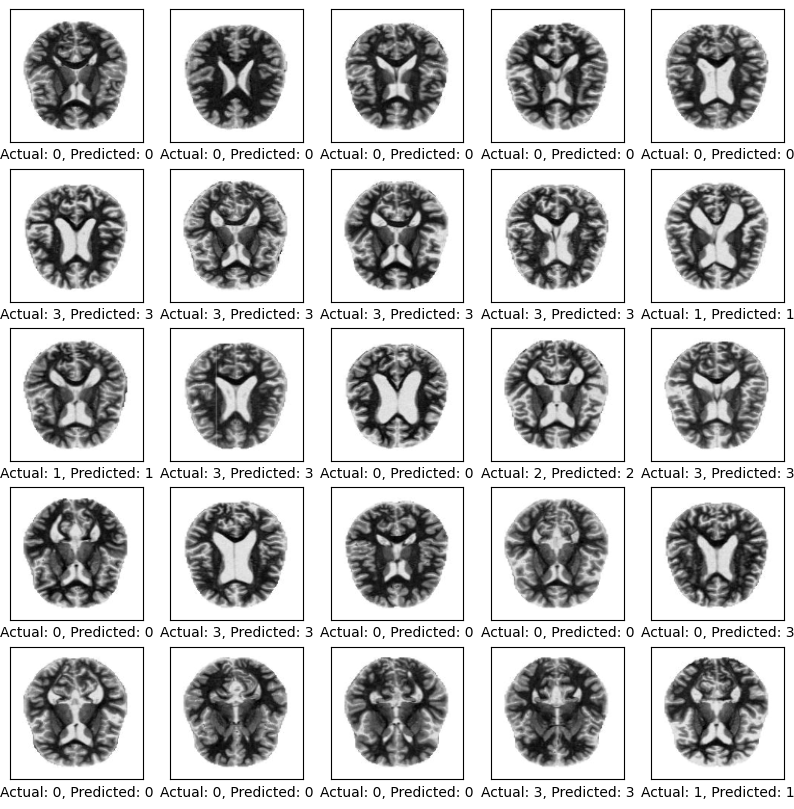

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Predict classes for the test data
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

# Display the images along with their actual and predicted classes
plt.figure(figsize=(10, 10))
for i in range(25):  # Display the first 25 images
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_test[i], cmap=plt.cm.binary)
    actual_label = np.argmax(y_test[i])  # Assuming y_test is one-hot encoded
    predicted_label = predicted_classes[i]

    plt.xlabel(f"Actual: {actual_label}, Predicted: {predicted_label}")
plt.show()


# KNN

In [29]:

from sklearn.neighbors import KNeighborsClassifier

# Create the KNN model

knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(xtrain, ytrain)

# Predict
knn_predictions = knn.predict(xtest)

# Get accuracy
knn_accuracy = accuracy_score(ytest, knn_predictions)

# Other evaluation metrics
print(f"KNN Accuracy: {knn_accuracy}")
print(classification_report(ytest, knn_predictions))


KNN Accuracy: 0.9590110605074821
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       774
           1       0.98      0.91      0.94       220
           2       1.00      0.90      0.95        10
           3       0.96      0.95      0.95       533

    accuracy                           0.96      1537
   macro avg       0.97      0.94      0.95      1537
weighted avg       0.96      0.96      0.96      1537



In [264]:
cf_matrix= confusion_matrix(knn_predictions,ytest)
cf_matrix

array([[759,  14,   1,  23],
       [  0, 201,   0,   5],
       [  0,   0,   9,   0],
       [ 15,   5,   0, 505]], dtype=int64)

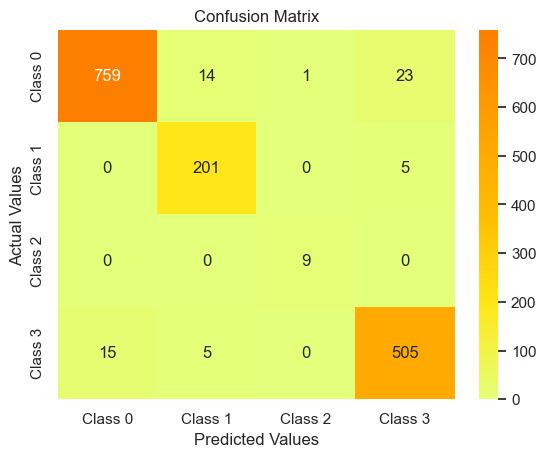

In [267]:
df_cm = pd.DataFrame(cf_matrix, index=['Class 0', 'Class 1', 'Class 2', 'Class 3'], columns=['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Generate the heatmap with annotations and a specified color map
ax = sns.heatmap(df_cm, annot=True, cmap='Wistia', fmt='d')  # 'fmt='d'' ensures integers are shown properly

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Display the visualization of the Confusion Matrix
plt.show()

In [120]:
knnprec = precision_score(ytest,knn_predictions,average='macro')	
print(knnprec)

0.9724885304403765


In [121]:
knnrec = recall_score(ytest,knn_predictions,average='macro')
print(knnrec)

0.9354309214136213


In [122]:
knnf = f1_score(ytest,knn_predictions,average='macro')
print(knnf)

0.9529813248155264


# Naive-Bayes

In [107]:
from sklearn.naive_bayes import GaussianNB

# Create the Gaussian Naive Bayes model
nb = GaussianNB()

# Train the model
nb.fit(xtrain, ytrain)

# Predict
nb_predictions = nb.predict(xtest)

# Get accuracy
nb_accuracy = accuracy_score(ytest, nb_predictions)

# Other evaluation metrics
print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(classification_report(ytest, nb_predictions))


Naive Bayes Accuracy: 0.5302537410540012
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       774
           1       0.31      0.62      0.41       220
           2       0.12      0.10      0.11        10
           3       0.47      0.29      0.36       533

    accuracy                           0.53      1537
   macro avg       0.40      0.42      0.39      1537
weighted avg       0.56      0.53      0.53      1537



In [123]:
nbprec = precision_score(ytest,nb_predictions,average='macro')	
print(nbprec)

0.3984503683845789


In [124]:
nbrec = recall_score(ytest,nb_predictions,average='macro')
print(nbrec)

0.42169606642805735


In [125]:
nbf = f1_score(ytest,nb_predictions,average='macro')
print(nbf)

0.39089657392955335


# XGBOOST

In [104]:
import xgboost as xgb

# Create the XGBoost model
xgboost = xgb.XGBClassifier()

# Train the model
xgboost.fit(xtrain, ytrain)

# Predict
xgb_predictions = xgboost.predict(xtest)

# Get accuracy
xgb_accuracy = accuracy_score(ytest, xgb_predictions)

# Other evaluation metrics
print(f"XGBoost Accuracy: {xgb_accuracy}")
print(classification_report(ytest, xgb_predictions))


XGBoost Accuracy: 0.973975276512687
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       774
           1       1.00      0.91      0.95       220
           2       1.00      1.00      1.00        10
           3       0.97      0.96      0.97       533

    accuracy                           0.97      1537
   macro avg       0.98      0.97      0.98      1537
weighted avg       0.97      0.97      0.97      1537



In [126]:
xgbprec = precision_score(ytest,xgb_predictions,average='macro')	
print(xgbprec)

0.9836833008695061


In [127]:
xgbrec = recall_score(ytest,xgb_predictions,average='macro')
print(xgbrec)

0.96885127618962


In [128]:
xgbf = f1_score(ytest,xgb_predictions,average='macro')
print(xgbf)

0.9757967807226458


# Testing KNN, NB,XGBOOST

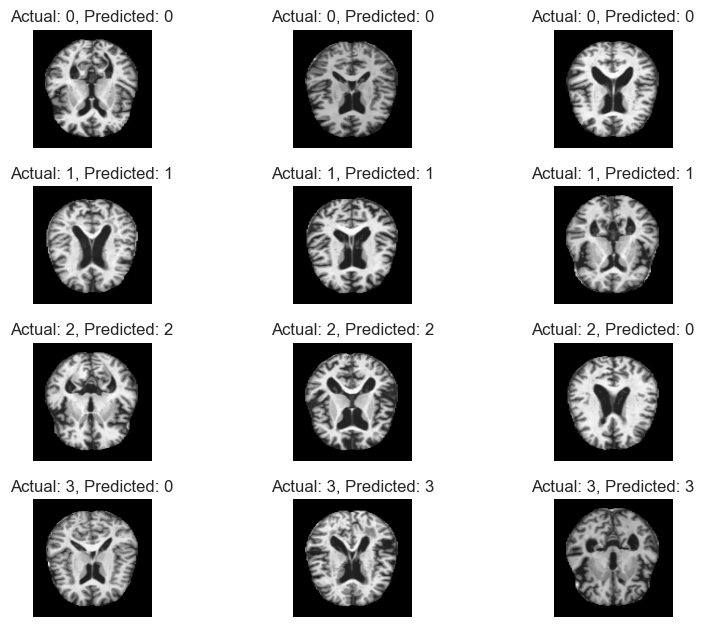

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predicted_labels, y_test, and x_test available

# Group indices of the test data by their actual labels
class_indices = {}
for idx, label in enumerate(ytest):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)

# Predict on the test set
predicted_labels = knn.predict(xtest)

# Display a representative image from each class
num_classes_to_display = 5  # Number of classes to display
images_per_class = 3  # Number of images per class to display

plt.figure(figsize=(8, 8))
for class_label in list(class_indices.keys())[:num_classes_to_display]:
    indices = class_indices[class_label][:images_per_class]
    for i, idx in enumerate(indices):
        image = xtest[idx].reshape(128, 128)  # Assuming the image size is 128x128
        plt.subplot(num_classes_to_display, images_per_class, class_label * images_per_class + i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Actual: {ytest[idx]}, Predicted: {predicted_labels[idx]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


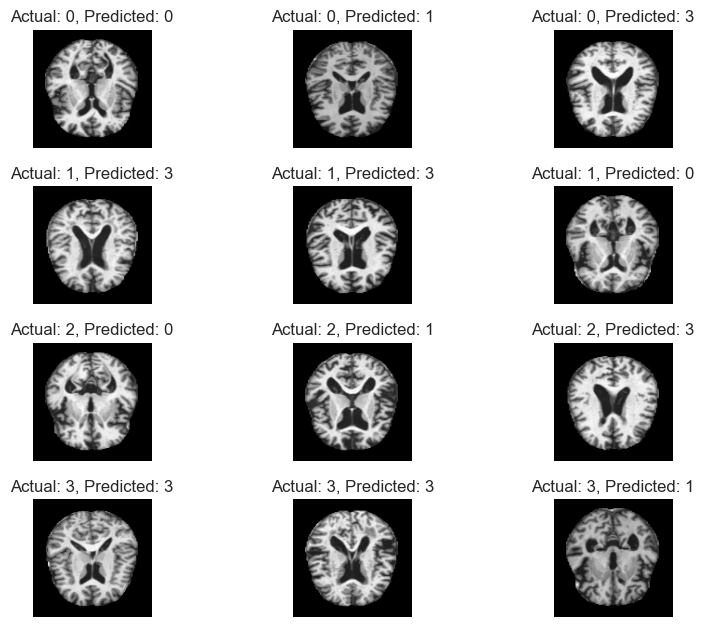

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predicted_labels, y_test, and x_test available

# Group indices of the test data by their actual labels
class_indices = {}
for idx, label in enumerate(ytest):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)

# Predict on the test set
predicted_labels = nb.predict(xtest)

# Display a representative image from each class
num_classes_to_display = 5  # Number of classes to display
images_per_class = 3  # Number of images per class to display

plt.figure(figsize=(8, 8))
for class_label in list(class_indices.keys())[:num_classes_to_display]:
    indices = class_indices[class_label][:images_per_class]
    for i, idx in enumerate(indices):
        image = xtest[idx].reshape(128, 128)  # Assuming the image size is 128x128
        plt.subplot(num_classes_to_display, images_per_class, class_label * images_per_class + i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Actual: {ytest[idx]}, Predicted: {predicted_labels[idx]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


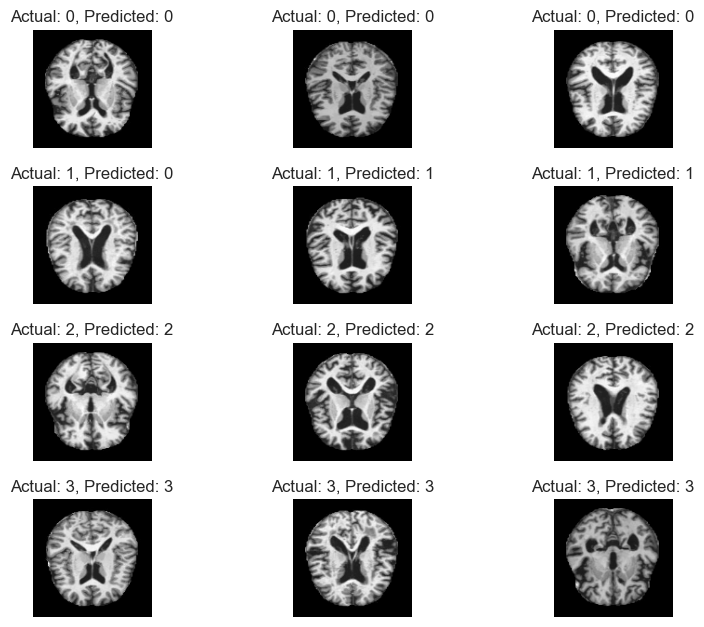

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predicted_labels, y_test, and x_test available

# Group indices of the test data by their actual labels
class_indices = {}
for idx, label in enumerate(ytest):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)

# Predict on the test set
predicted_labels = xgboost.predict(xtest)

# Display a representative image from each class
num_classes_to_display = 5  # Number of classes to display
images_per_class = 3  # Number of images per class to display

plt.figure(figsize=(8, 8))
for class_label in list(class_indices.keys())[:num_classes_to_display]:
    indices = class_indices[class_label][:images_per_class]
    for i, idx in enumerate(indices):
        image = xtest[idx].reshape(128, 128)  # Assuming the image size is 128x128
        plt.subplot(num_classes_to_display, images_per_class, class_label * images_per_class + i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Actual: {ytest[idx]}, Predicted: {predicted_labels[idx]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


# Performance Measure plots

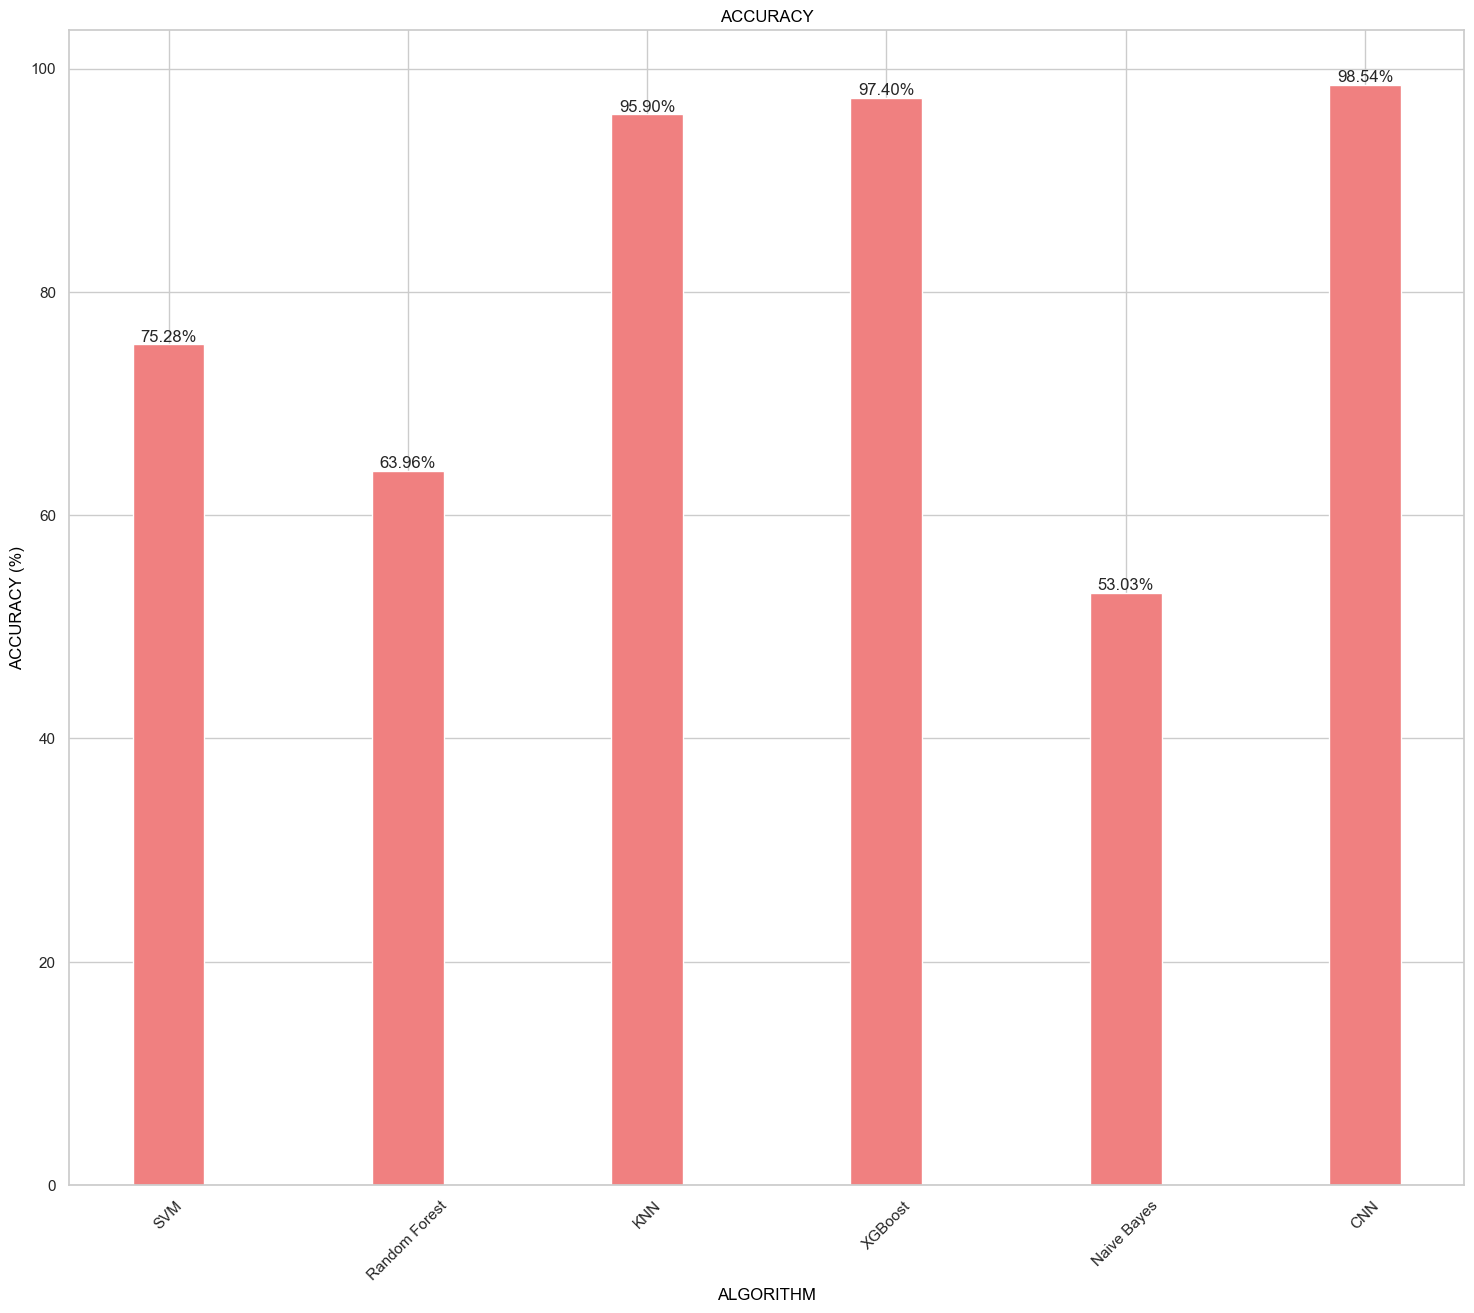

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have computed accuracy scores for various algorithms
x = np.array(["SVM", "Random Forest", "KNN", "XGBoost", "Naive Bayes","CNN"])
y = np.array([svmacc * 100, rfacc * 100, knn_accuracy * 100, xgb_accuracy * 100, nb_accuracy * 100,test_accuracy*100])

plt.figure(figsize=(18, 15))
plt.bar(x, y, width=0.3, color='lightcoral')

# Function to add labels on top of the bars
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], f"{y[i]:.2f}%", ha='center', va='bottom')

addlabels(x, y)
plt.title('ACCURACY', color='black')
plt.xlabel("ALGORITHM", color='black')
plt.ylabel("ACCURACY (%)", color='black')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


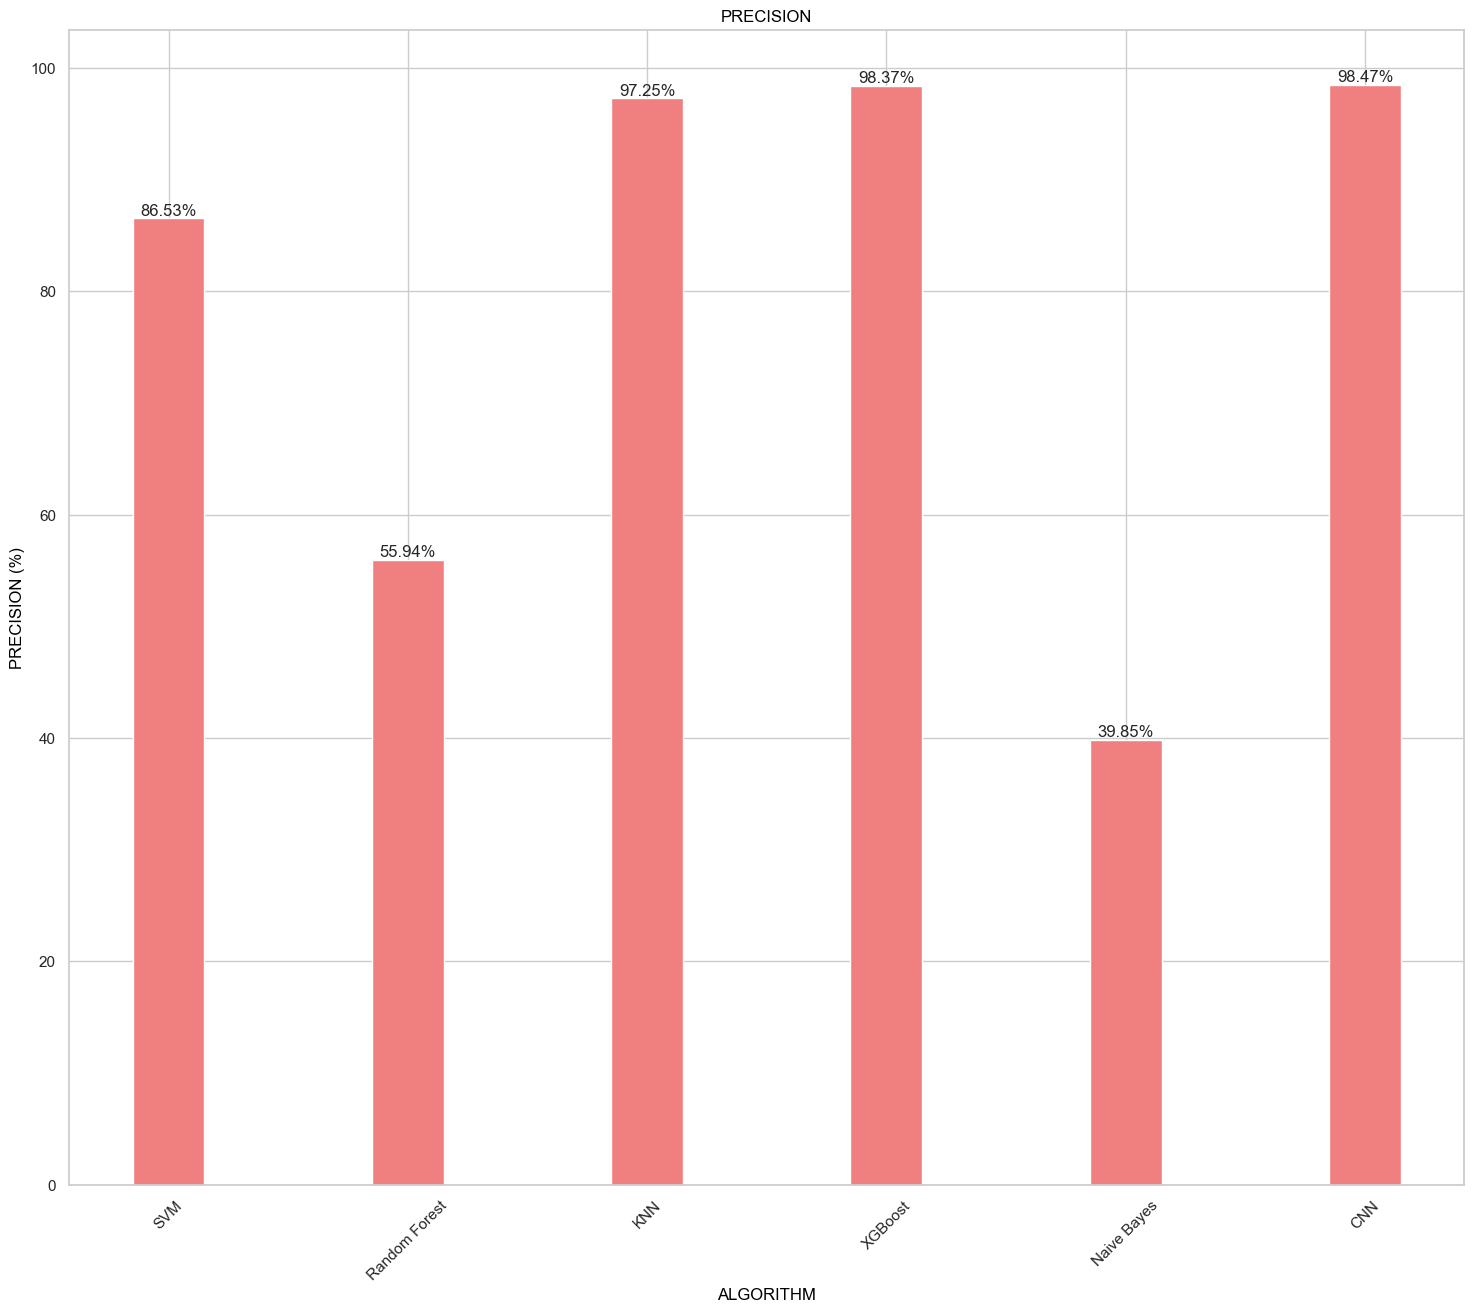

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have computed precision scores for various algorithms
x = np.array(["SVM", "Random Forest", "KNN", "XGBoost", "Naive Bayes","CNN"])
y = np.array([svmprec * 100, rfprec * 100, knnprec * 100, xgbprec * 100, nbprec * 100,precision*100])

plt.figure(figsize=(18, 15))
plt.bar(x, y, width=0.3, color='lightcoral')

# Function to add labels on top of the bars
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], f"{y[i]:.2f}%", ha='center', va='bottom')

addlabels(x, y)
plt.title('PRECISION', color='black')
plt.xlabel("ALGORITHM", color='black')
plt.ylabel("PRECISION (%)", color='black')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


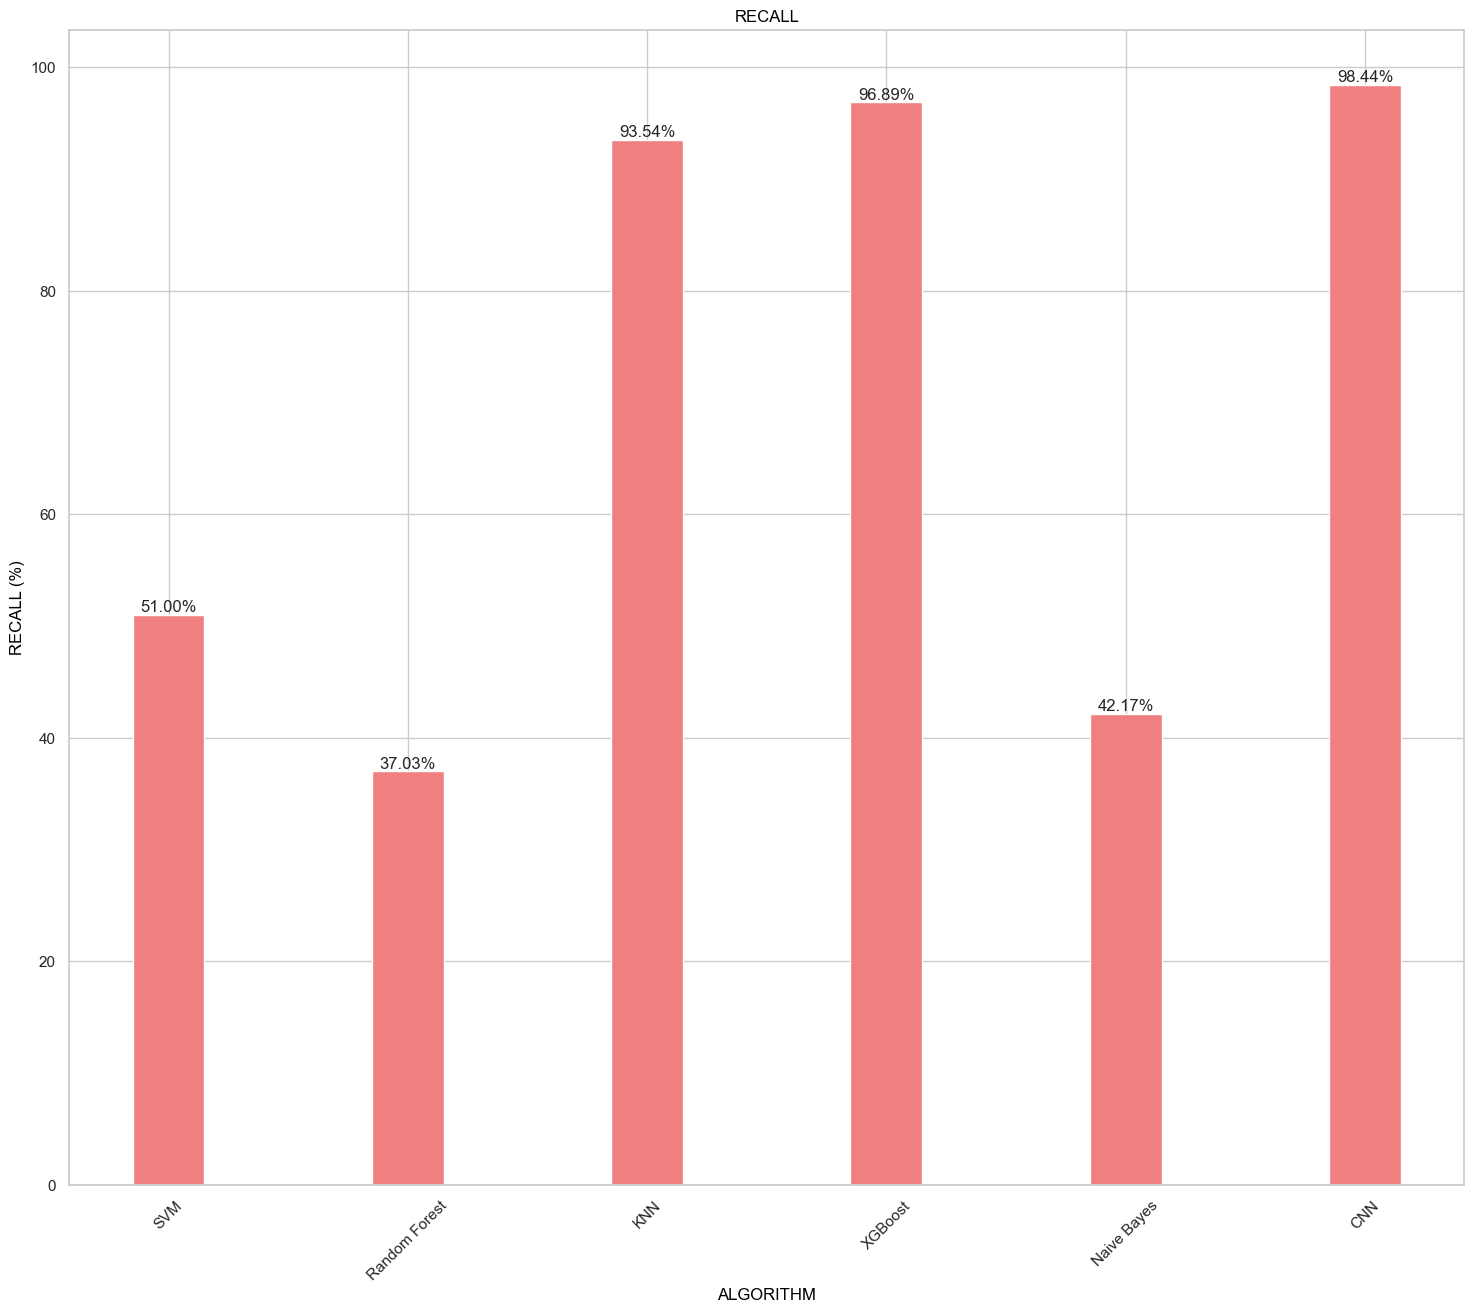

In [143]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have computed recall scores for various algorithms
x = np.array(["SVM", "Random Forest", "KNN", "XGBoost", "Naive Bayes","CNN"])
y = np.array([svmrec * 100, rfrec * 100, knnrec * 100, xgbrec * 100, nbrec * 100,recall*100])

plt.figure(figsize=(18, 15))
plt.bar(x, y, width=0.3, color='lightcoral')

# Function to add labels on top of the bars
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], f"{y[i]:.2f}%", ha='center', va='bottom')

addlabels(x, y)
plt.title('RECALL', color='black')
plt.xlabel("ALGORITHM", color='black')
plt.ylabel("RECALL (%)", color='black')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


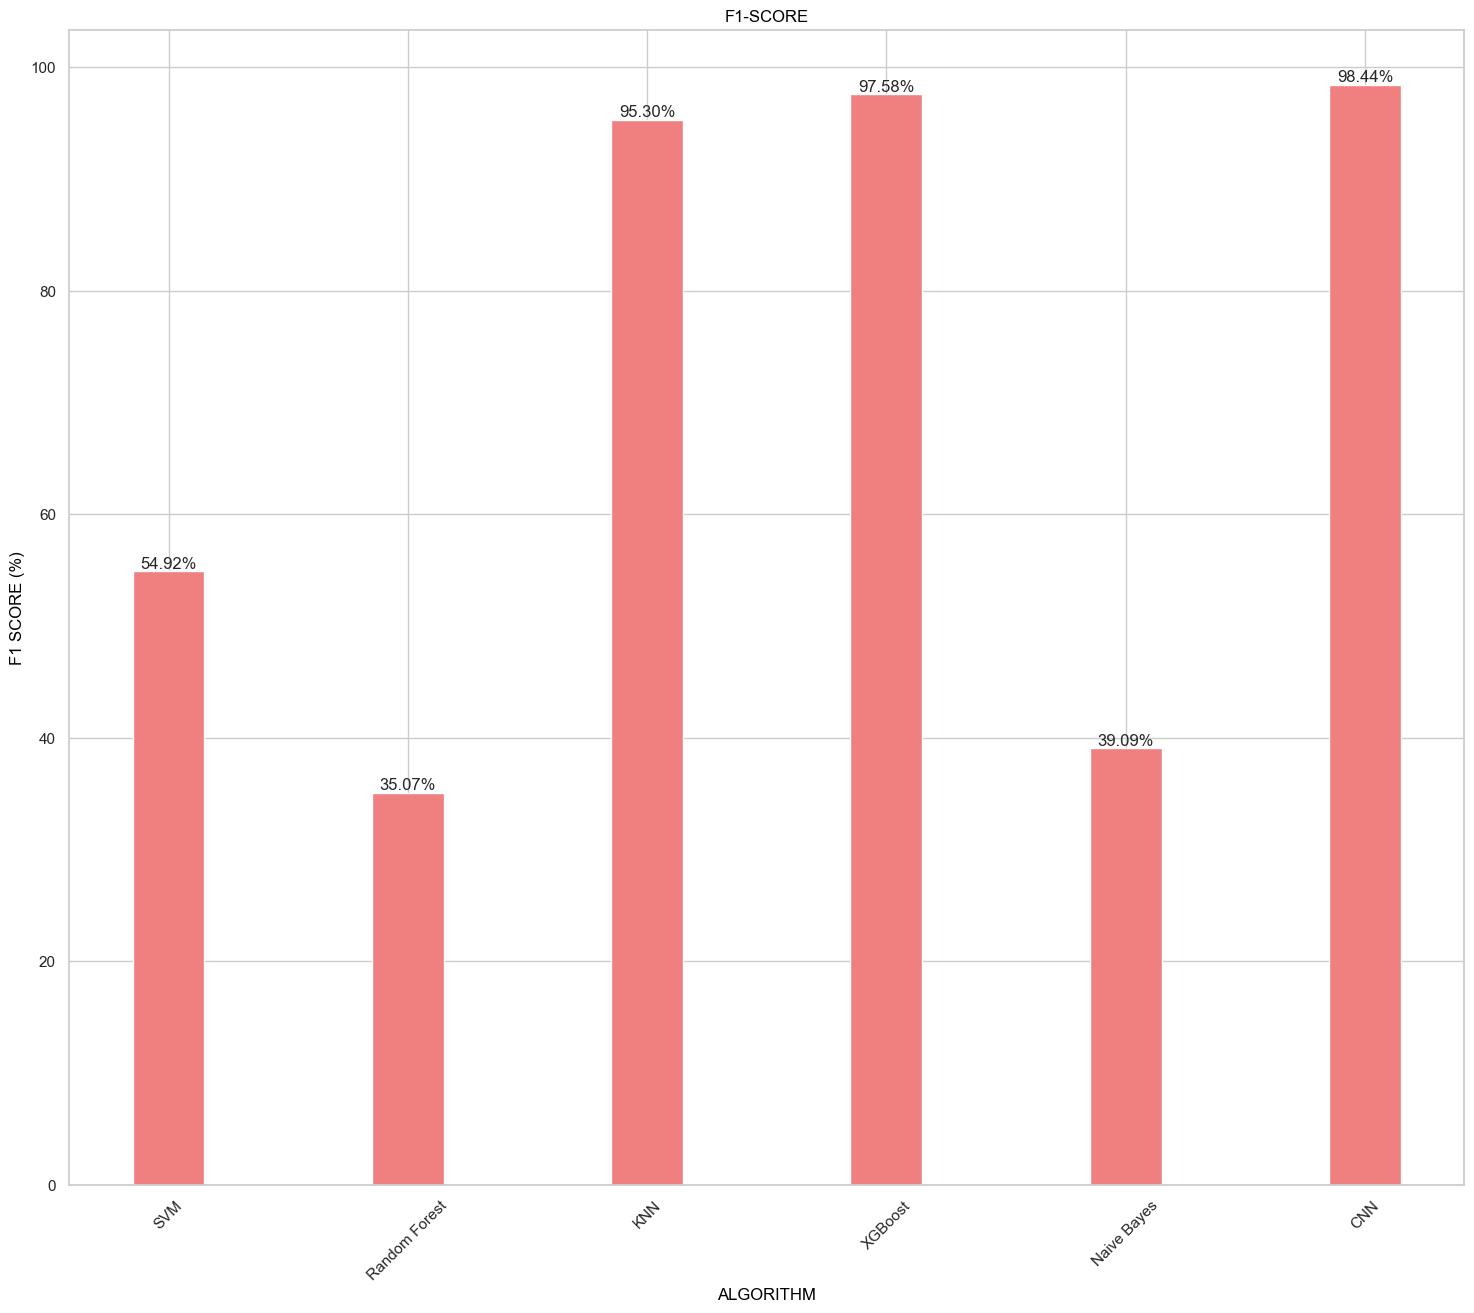

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have computed F1 scores for various algorithms
x = np.array(["SVM", "Random Forest", "KNN", "XGBoost", "Naive Bayes","CNN"])
y = np.array([svmf * 100, rff * 100, knnf * 100, xgbf * 100, nbf * 100,f1*100])

plt.figure(figsize=(18, 15))
plt.bar(x, y, width=0.3, color='lightcoral')

# Function to add labels on top of the bars
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], f"{y[i]:.2f}%", ha='center', va='bottom')

addlabels(x, y)
plt.title('F1-SCORE', color='black')
plt.xlabel("ALGORITHM", color='black')
plt.ylabel("F1 SCORE (%)", color='black')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


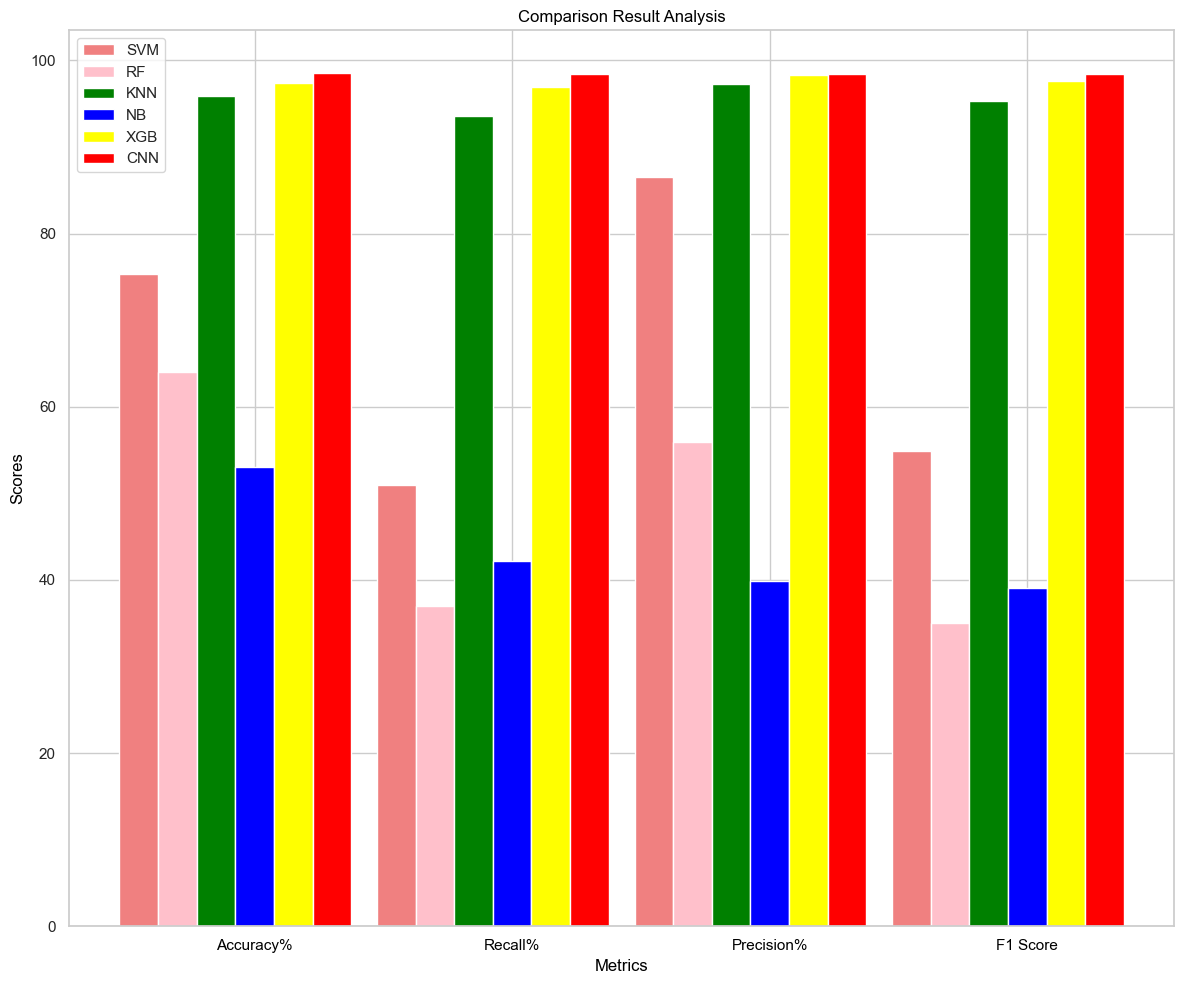

In [165]:
import numpy as np
import matplotlib.pyplot as plt


X = ['Accuracy%', 'Recall%', 'Precision%', 'F1 Score']
svm_stats = [svmacc*100, svmrec*100, svmprec*100, svmf*100]
rf_stats = [rfacc*100, rfrec*100, rfprec*100, rff*100]
# ... stats for other algorithms
knn_stats = [knn_accuracy*100, knnrec*100, knnprec*100, knnf*100]
nb_stats = [nb_accuracy*100, nbrec*100, nbprec*100, nbf*100]
xgb_stats = [xgb_accuracy*100, xgbrec*100, xgbprec*100, xgbf*100]
cnn_stats = [test_accuracy*100, recall*100, precision*100, f1*100]

X_axis = np.arange(len(X))
plt.figure(figsize=(12, 10))  # Adjust figure size to suit your display

bar_width = 0.15  # Width of each bar

plt.bar(X_axis - 3 * bar_width, svm_stats, bar_width, label='SVM', color='lightcoral')
plt.bar(X_axis - 2 * bar_width, rf_stats, bar_width, label='RF', color='pink')
plt.bar(X_axis - 1 * bar_width, knn_stats, bar_width, label='KNN', color='green')
plt.bar(X_axis, nb_stats, bar_width, label='NB', color='blue')
plt.bar(X_axis + 1 * bar_width, xgb_stats, bar_width, label='XGB', color='yellow')
plt.bar(X_axis + 2 * bar_width, cnn_stats, bar_width, label='CNN', color='red')

plt.xticks(X_axis, X, color='black')
plt.xlabel("Metrics", color='black')
plt.ylabel("Scores", color='black')
plt.title("Comparison Result Analysis", color='black')
plt.legend()
plt.tight_layout()
plt.show()


In [167]:
predicted_labels = xgboost.predict([xtest[45]])


In [169]:
print(predicted_labels)
print(ytest[45])


[3]
3
